In [0]:
# upload your kaggle API credentials first
!mv kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dogs-vs-cats

 96% 260M/271M [00:03<00:00, 84.4MB/s]
100% 271M/271M [00:03<00:00, 92.4MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 77.0MB/s]
 96% 524M/543M [00:08<00:00, 66.5MB/s]
100% 543M/543M [00:08<00:00, 65.7MB/s]


In [0]:
!unzip train.zip
!mv train data
!rm test1.zip sampleSubmission.csv train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      

In [0]:
DATASET_LOCATION = "data"

In [0]:
import os
filenames = os.listdir(DATASET_LOCATION)
classes = []
for filename in filenames:
    image_class = filename.split('.')[0]
    if image_class == 'dog':
        classes.append(1)
    else:
        classes.append(0)

In [0]:
import pandas as pd
df = pd.DataFrame({
    'filename': filenames,
    'category': classes
})
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [0]:
df.head()

,filename,category
0,dog.1018.jpg,dog
1,cat.3005.jpg,cat
2,dog.5561.jpg,dog
3,cat.9000.jpg,cat
4,cat.2559.jpg,cat


In [0]:
df.category.value_counts()

cat    12500
dog    12500
Name: category, dtype: int64

Using TensorFlow backend.


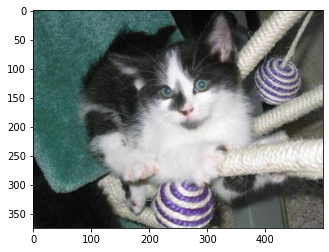

In [0]:
import random
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
sample1 = random.choice(filenames)
image1 = load_img(DATASET_LOCATION+"/"+sample1)
plt.imshow(image1)

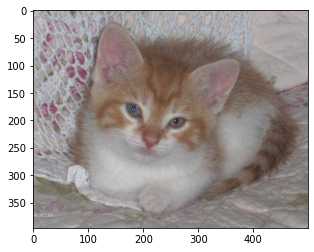

In [0]:
sample2 = random.choice(filenames)
image2 = load_img(DATASET_LOCATION+"/"+sample2)
plt.imshow(image2)

In [0]:
image1.size

(499, 375)

In [0]:
image2.size

(500, 396)

In [0]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
INPUT_SHAPE=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)

In [0]:
BATCH_SIZE = 16

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATASET_LOCATION, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

Found 20000 validated image filenames belonging to 2 classes.


In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    DATASET_LOCATION, 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
example_df = train_df.sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    DATASET_LOCATION, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1 validated image filenames belonging to 1 classes.


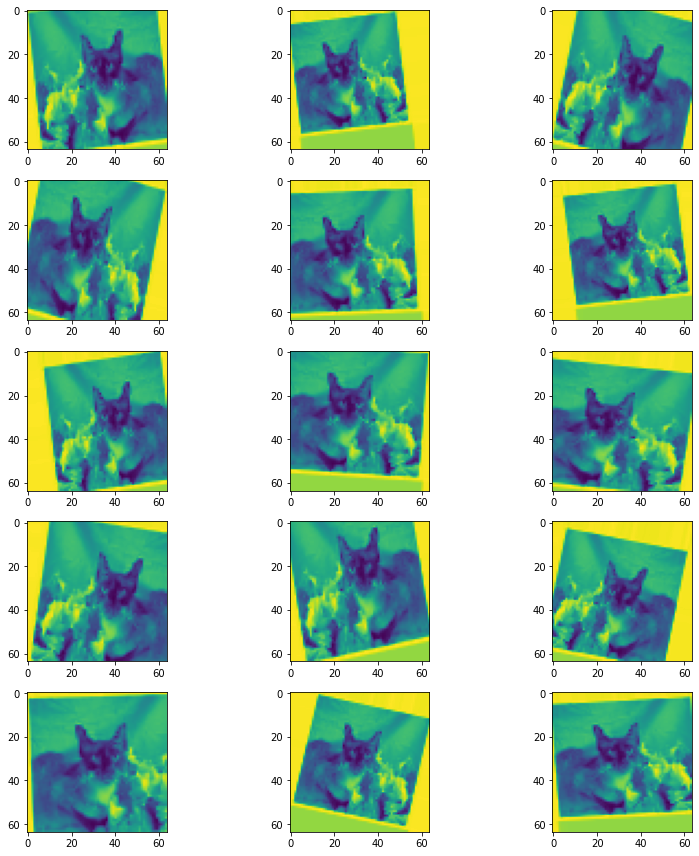

In [0]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        image = image.reshape(IMAGE_SIZE)
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [0]:
EPOCHS = 10
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//BATCH_SIZE,
    steps_per_epoch=train_df.shape[0]//BATCH_SIZE
)

Epoch 1/10
1250/1250 [==============================] - 82s 65ms/step - loss: 0.5857 - accuracy: 0.6933 - val_loss: 0.5121 - val_accuracy: 0.7292
Epoch 2/10
1250/1250 [==============================] - 81s 65ms/step - loss: 0.5598 - accuracy: 0.7131 - val_loss: 0.3766 - val_accuracy: 0.7546
Epoch 3/10
1250/1250 [==============================] - 81s 65ms/step - loss: 0.5464 - accuracy: 0.7251 - val_loss: 0.4113 - val_accuracy: 0.7448
Epoch 4/10
1250/1250 [==============================] - 81s 65ms/step - loss: 0.5372 - accuracy: 0.7296 - val_loss: 0.3429 - val_accuracy: 0.7765
Epoch 5/10
1250/1250 [==============================] - 81s 65ms/step - loss: 0.5294 - accuracy: 0.7391 - val_loss: 0.6141 - val_accuracy: 0.7763
Epoch 6/10
1250/1250 [==============================] - 81s 65ms/step - loss: 0.5208 - accuracy: 0.7425 - val_loss: 0.3792 - val_accuracy: 0.7731
Epoch 7/10
1250/1250 [==============================] - 82s 66ms/step - loss: 0.5169 - accuracy: 0.7456 - val_loss: 0.3608 -

In [0]:
NUM_SAMPLES = 6
sample_test_df = test_df.head(NUM_SAMPLES).reset_index(drop=True)
sample_test_datagen = ImageDataGenerator(rescale=1./255)
sample_test_generator = sample_test_datagen.flow_from_dataframe(
    sample_test_df, 
    DATASET_LOCATION, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

Found 6 validated image filenames belonging to 2 classes.


In [0]:
predict = model.predict_generator(sample_test_generator)

In [0]:
import numpy as np
predictions = np.argmax(predict, axis=-1)

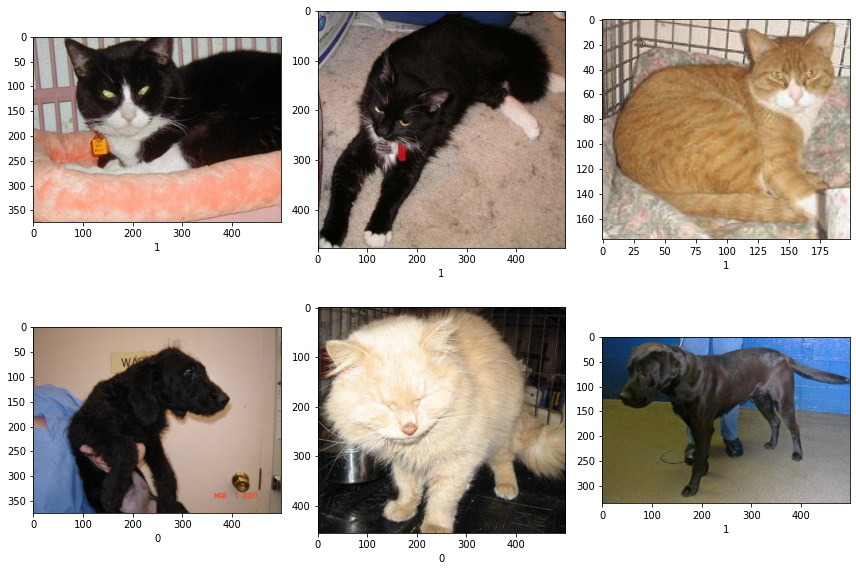

In [0]:
plt.figure(figsize=(12, 24))
for index, row in sample_test_df.iterrows():
    filename = row['filename']
    prediction = predictions[index]
    img = load_img(DATASET_LOCATION+"/"+filename)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(prediction)
plt.tight_layout()
plt.show()